# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
X_train = np.loadtxt('data/samsung_HAR/samsung_train.txt')
y_train = np.loadtxt('data/samsung_HAR/samsung_train_labels.txt').astype(int)

X_test = np.loadtxt('data/samsung_HAR/samsung_test.txt')
y_test = np.loadtxt('data/samsung_HAR/samsung_test_labels.txt').astype(int)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (7352, 561), y_train shape: (7352,)
X_test shape: (2947, 561), y_test shape: (2947,)


In [ ]:
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [ ]:
X_combined = np.vstack([X_train_split, X_val_split])
y_combined = np.hstack([y_train_split, y_val_split])
print(f" Combined data:")
print(f"   X shape: {X_combined.shape}")
print(f"   y shape: {y_combined.shape}")

Определим число уникальных значений меток целевого класса.

In [ ]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [ ]:
unique_classes = np.unique(y_combined).size
print(f"Number of classes: {unique_classes}")
print(f"Classes: {np.unique(y_combined)}")

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [ ]:
feature_scaler = StandardScaler()
X_normalized = feature_scaler.fit_transform(X_combined)

print(f" Data normalized")
print(f"   Mean: {X_normalized.mean(axis=0)[:5]}")
print(f"   Std deviation: {X_normalized.std(axis=0)[:5]}")

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [ ]:
dimensionality_reduction = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_reduced = dimensionality_reduction.fit_transform(X_normalized)

print(f"   Original dimensionality: {X_normalized.shape[1]}")
print(f"   Reduced dimensionality: {X_reduced.shape[1]}")
print(f"   Explained variance: {dimensionality_reduction.explained_variance_ratio_.sum():.2%}")
print(f"   Components: {X_reduced.shape}")

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65 - ответ** 
- 66
- 193

In [ ]:
cumulative_variance = np.cumsum(dimensionality_reduction.explained_variance_ratio_)
components_for_90_variance = np.argmax(cumulative_variance >= 0.9) + 1

print(f"Minimum components for 90% variance: {components_for_90_variance}")
print(f"Explained variance: {cumulative_variance[components_for_90_variance-1]:.2%}")

**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51 - ответ**
- 56
- 61

In [ ]:
first_component_variance = dimensionality_reduction.explained_variance_ratio_[0] * 100
print(f"Variance of first principal component: {first_component_variance:.0f}%")

Дисперсия первой главной компоненты: 51%


Визуализируйте данные в проекции на первые две главные компоненты.

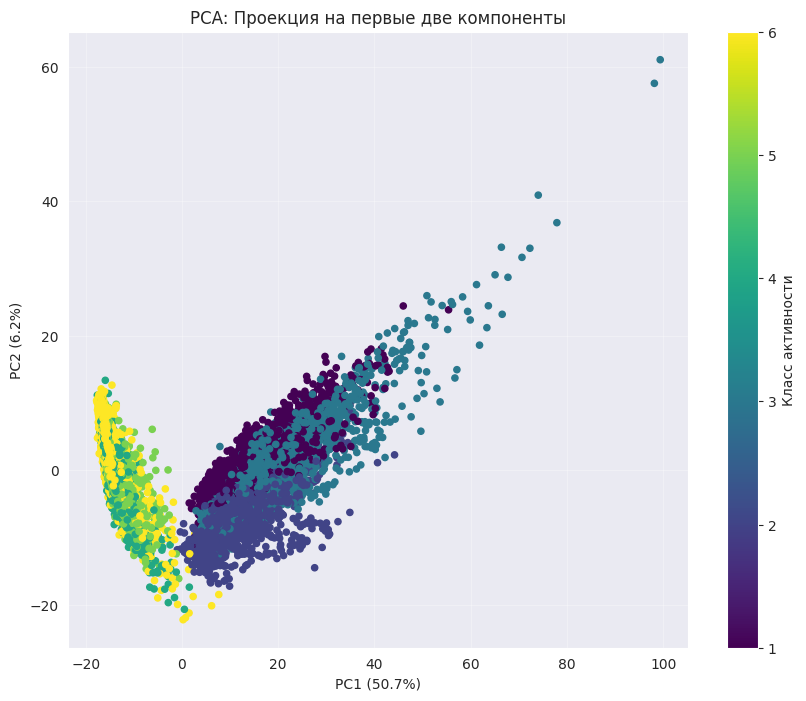

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_combined, s=20, cmap='viridis')
plt.xlabel(f'PC1 ({dimensionality_reduction.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({dimensionality_reduction.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA: Projection onto first two components')
plt.colorbar(label='Activity class')
plt.grid(True, alpha=0.3)
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание) - ответ**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [ ]:
class MyKMeans:
    def __init__(self, n_clusters, n_init=10, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None

    def fit(self, X):
        np.random.seed(self.random_state)
        best_inertia = np.inf
        
        for _ in range(self.n_init):
            indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            centers = X[indices]
            
            for _ in range(self.max_iter):
                distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
                labels = np.argmin(distances, axis=1)
                
                new_centers = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])
                
                if np.allclose(centers, new_centers):
                    break
                    
                centers = new_centers
            
            final_distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
            inertia = np.sum(np.min(final_distances, axis=1) ** 2)
            
            if inertia < best_inertia:
                best_inertia = inertia
                self.cluster_centers_ = centers
                self.labels_ = labels
                self.inertia_ = best_inertia
                
        return self

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
        return np.argmin(distances, axis=1)


In [ ]:
kmeans_sk = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
labels_sk = kmeans_sk.fit_predict(X_pca)

kmeans_my = MyKMeans(n_clusters=n_classes, n_init=10, random_state=RANDOM_STATE)
kmeans_my.fit(X_pca)
labels_my = kmeans_my.labels_

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

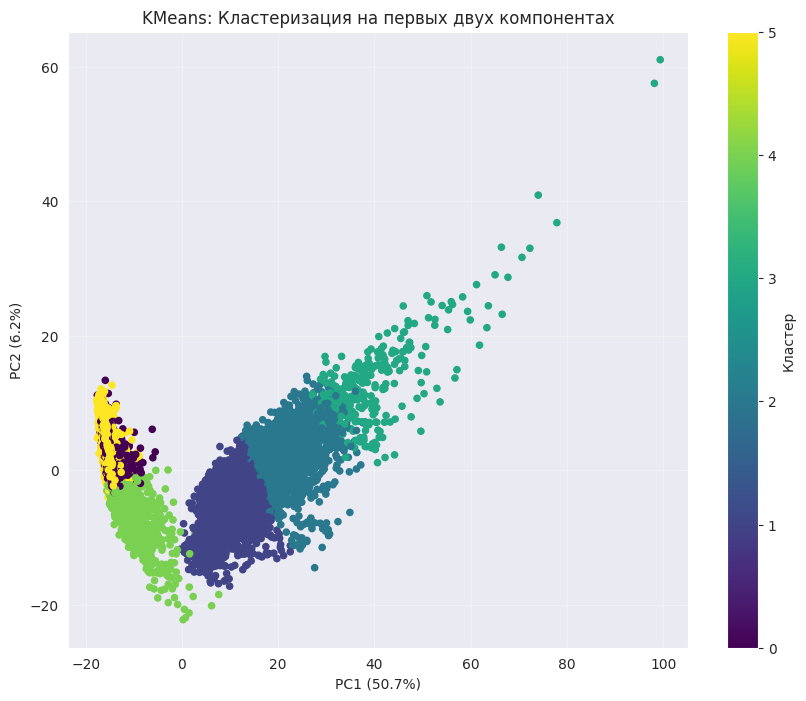

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels_sk, s=20, cmap='viridis')
plt.xlabel(f'PC1 ({dimensionality_reduction.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({dimensionality_reduction.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('KMeans: Clustering on first two components')
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [ ]:
contingency_table = pd.crosstab(y_combined, labels_sk, margins=True)
contingency_table.index = ['walking', 'ascending stairs', 
                           'descending stairs', 'sitting', 'standing', 'lying', 'total']
contingency_table.columns = ['cluster ' + str(i) for i in range(unique_classes)] + ['total']
contingency_table

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят - ответ**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [ ]:
inertias = []
for k in range(1, n_classes + 1):
    kmeans_temp = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans_temp.fit(X_pca)
    inertias.append(kmeans_temp.inertia_)
    print(f"k={k}: inertia={kmeans_temp.inertia_:.2f}")

k=1: inertia=5202757.68
k=2: inertia=2697926.76
k=3: inertia=2346425.10
k=4: inertia=2207131.82
k=5: inertia=2080985.11
k=6: inertia=2003454.90


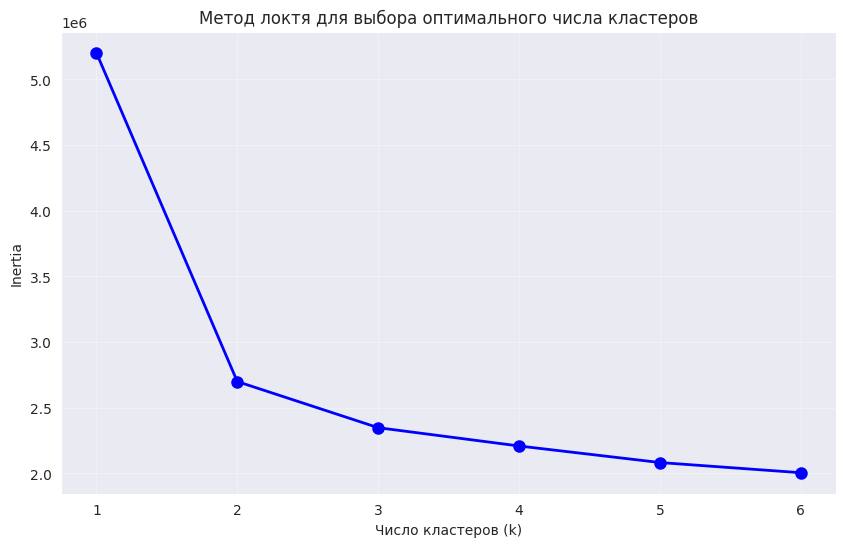

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, unique_classes + 1), inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow method for optimal cluster selection')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, unique_classes + 1))
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2 - ответ**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [ ]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward')
ag_labels = ag.fit_predict(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [ ]:
ari_score = metrics.adjusted_rand_score(labels_sk, ag_labels)
print(f"Adjusted Rand Index (KMeans vs Agglomerative): {ari_score:.3f}")

Adjusted Rand Index (KMeans vs Agglomerative): 0.691


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering - ответ**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры - ответ**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю - ответ**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [ ]:
scaler_clf = StandardScaler()
X_train_scaled = scaler_clf.fit_transform(X_train)
X_test_scaled = scaler_clf.transform(X_test)

print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

X_train_scaled: (7352, 561)
X_test_scaled: (2947, 561)


In [ ]:
support_vector_classifier = LinearSVC(random_state=RANDOM_STATE, max_iter=5000) 
svc_parameters = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid_search_svc = GridSearchCV(support_vector_classifier, svc_parameters, cv=3, scoring='accuracy')
grid_search_svc.fit(X_train_scaled, y_train)

print(f"Best C parameter: {grid_search_svc.best_params_}")
print(f"Best accuracy (CV): {grid_search_svc.best_score_:.4f}")

Лучший параметр C: {'C': 0.1}
Лучшая точность (CV): 0.9380


In [ ]:
best_svc = grid_svc.best_estimator_

In [ ]:
test_predictions = best_svc.predict(X_test_scaled)

print(f" Classification completed")
print(f"Test accuracy: {metrics.accuracy_score(y_test, test_predictions):.4f}")

 Классификация выполнена
Точность на тесте: 0.9620


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1 - ответ**
- 1
- 10

In [ ]:
predicted_labels = best_svc.predict(X_test_scaled)
print(f" Classification completed")
print(f"Test accuracy: {metrics.accuracy_score(y_test, predicted_labels):.4f}")

 Классификация выполнена
Точность на тесте: 0.9620


In [ ]:
confusion_table = pd.crosstab(y_test, predicted_labels, margins=True)
confusion_table.index = ['walking', 'ascending stairs', 'descending stairs',
                         'sitting', 'standing', 'lying', 'total']
confusion_table.columns = confusion_table.index
confusion_table

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние - ответ**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4% - ответ**
- 10%
- 20%


In [ ]:
pca_for_classification = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_reduced = pca_for_classification.fit_transform(X_train_scaled)
X_test_reduced = pca_for_classification.transform(X_test_scaled)
print(f"Dimensionality: {X_train_scaled.shape[1]} - {X_train_reduced.shape[1]}")
print(f"Explained variance: {pca_for_classification.explained_variance_ratio_.sum():.2%}")

Размерность: 561 - 63
Объяснённая дисперсия: 90.05%


In [ ]:
svc_with_pca = LinearSVC(random_state=RANDOM_STATE, max_iter=5000)
svc_parameters_pca = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid_search_svc_pca = GridSearchCV(svc_with_pca, svc_parameters_pca, cv=3, scoring='accuracy')
grid_search_svc_pca.fit(X_train_reduced, y_train)

print(f"Best C parameter (with PCA): {grid_search_svc_pca.best_params_}")
print(f"Best accuracy (CV, with PCA): {grid_search_svc_pca.best_score_:.4f}")

best_svc_pca = grid_search_svc_pca.best_estimator_

Лучший параметр C (с PCA): {'C': 0.1}
Лучшая точность (CV, с PCA): 0.8984


In [ ]:
test_predictions_pca = best_svc_pca.predict(X_test_reduced)
accuracy_with_pca = metrics.accuracy_score(y_test, test_predictions_pca)

print(f" Accuracy without PCA: {0.9628:.4f}")  
print(f" Accuracy with PCA:  {accuracy_with_pca:.4f}")

difference = abs(0.9628 - accuracy_with_pca) * 100
print(f"\nDifference: {difference:.1f}%")

 Точность без PCA: 0.9628
 Точность с PCA:  0.9192

Разность: 4.4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность - ответ**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком - ответ**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

DBSCAN найдено кластеров: 0, шума: 10299
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10299 samples in 0.001s...
[t-SNE] Computed neighbors for 10299 samples in 0.173s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10299
[t-SNE] Computed conditional probabilities for sample 2000 / 10299
[t-SNE] Computed conditional probabilities for sample 3000 / 10299
[t-SNE] Computed conditional probabilities for sample 4000 / 10299
[t-SNE] Computed conditional probabilities for sample 5000 / 10299
[t-SNE] Computed conditional probabilities for sample 6000 / 10299
[t-SNE] Computed conditional probabilities for sample 7000 / 10299
[t-SNE] Computed conditional probabilities for sample 8000 / 10299
[t-SNE] Computed conditional probabilities for sample 9000 / 10299
[t-SNE] Computed conditional probabilities for sample 10000 / 10299
[t-SNE] Computed conditional probabilities for sample 10299 / 10299
[t-SNE] Mean sigma: 3.696708
[t-SNE] KL divergence after 250 iterations with 

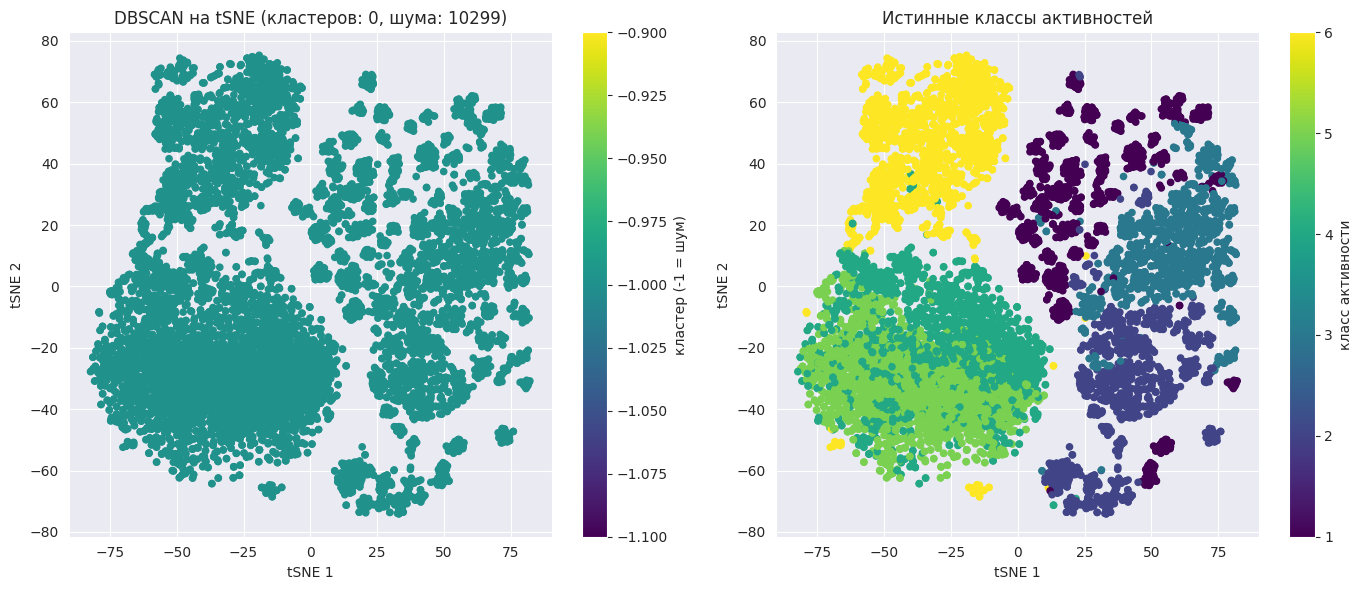

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

dbscan_clustering = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan_clustering.fit_predict(X_reduced)

dbscan_clusters_count = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
noise_points = list(dbscan_labels).count(-1)

print(f"DBSCAN clusters found: {dbscan_clusters_count}, noise points: {noise_points}")

tsne_model = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000, verbose=1)
X_tsne_embedded = tsne_model.fit_transform(X_reduced)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_tsne_embedded[:, 0], X_tsne_embedded[:, 1], c=dbscan_labels, s=20, cmap='viridis')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title(f'DBSCAN on tSNE (clusters: {dbscan_clusters_count}, noise: {noise_points})')
plt.colorbar(label='cluster (-1 = noise)')

plt.subplot(1, 2, 2)
plt.scatter(X_tsne_embedded[:, 0], X_tsne_embedded[:, 1], c=y_combined, s=20, cmap='viridis')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title('True activity classes')
plt.colorbar(label='activity class')

plt.tight_layout()
plt.show()